# Supervised Instruct-tuning OpenLLaMA Using Dolly15k Dataset

Tools/Libraries:
- [Hugging Face's PEFT Library](https://github.com/huggingface/peft)
- [Hugging Face's Transformers Library](https://huggingface.co/docs/transformers/index)
- [QLoRA](https://arxiv.org/abs/2305.14314)
- [TRL](https://github.com/lvwerra/trl/tree/main/docs/source)

In [ ]:
!pip install transformers==4.31.0
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

https://www.youtube.com/watch?v=eTieetk2dSw\

https://github.com/FourthBrain/Building-with-Instruction-Tuned-LLMs-A-Step-by-Step-Guide
https://colab.research.google.com/drive/1SRclU2pcgzCkVXpmhKppVbGW4UcCs5xT?usp=sharing#scrollTo=FuXIFTFapAMI


In [ ]:
from datasets import load_dataset

dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Visualizing the Data (Dolly15k)


In [ ]:
dbricks_15k_dataset_base

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > 2200:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

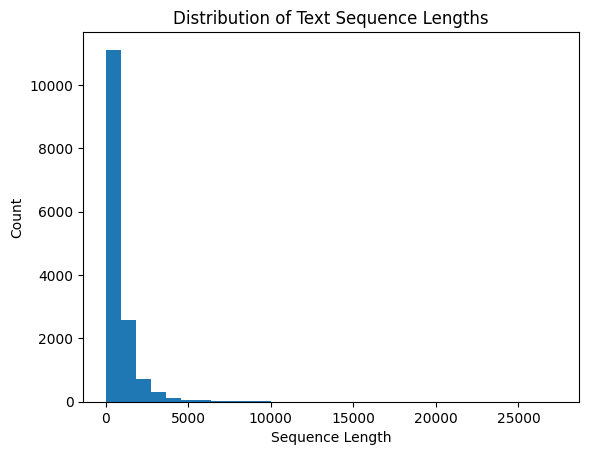

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_base)

Some of these sequences are too long. Let's eliminate the ones above 2200 characters.


In [ ]:
len(indexes_to_drop)

936

In [ ]:
dbricks_15k_dataset_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(indexes_to_drop)
)

Parameter 'indices'=<generator object <genexpr> at 0x7a9b65181a80> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
dbricks_15k_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14075
})

In [ ]:
dbricks_15k_dataset_prepared = dbricks_15k_dataset_reduced.train_test_split(test_size=0.1)

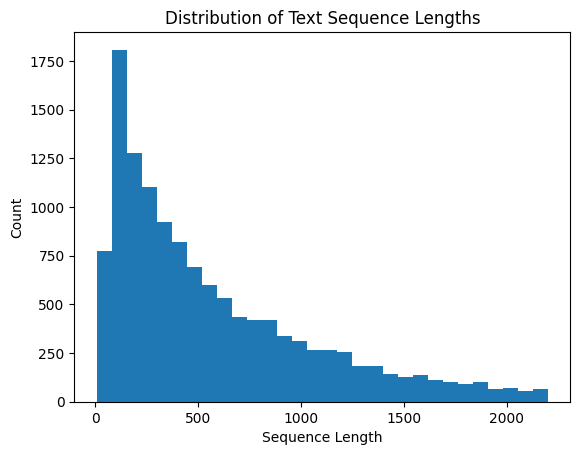

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_prepared)

In [ ]:
dbricks_15k_dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})

Prior to beginning training, we set up some helper functions that ensure our data is parsed in the desired format. Then, we save our PEFT (Parameter-Efficient Fine-Tuning) adapters.

In [ ]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [ ]:
formatted_dataset = dbricks_15k_dataset_prepared.map(formatting_func)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [ ]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1408
    })
})

In [ ]:
formatted_dataset["train"][2]["text"]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWho is the largest employer in the world?\n\n### Response:\nThe United States Department of Defense (DoD, USDOD or DOD) is an executive branch department of the federal government of the United States charged with coordinating and supervising all agencies and functions of the U.S. government directly related to national security and the United States Armed Forces. The DoD is the largest employer in the world, with over 1.34 million active-duty service members (soldiers, marines, sailors, airmen, and guardians) as of June 2022. The DoD also maintains over 778,000 National Guard and reservists, and over 747,000 civilians bringing the total to over 2.87 million employees. Headquartered at the Pentagon in Arlington, Virginia, just outside Washington, D.C., the DoD\'s stated mission is to provide "the military forces needed to deter war and ensure our nation\'s sec

We have now parsed Dolly15k down to a reasonable length. Let's set up the ML model.

Here, we will leverage QLoRA. This will ensure we use a lower amount of memory during fine-tuning. The basic idea of the paper is that for a more downstream task, less parameters need to be tuned. We can be efficient!

[Read more](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

We'll train on the Open LLaMA 7-billion parameter version.

In [ ]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "openlm-research/open_llama_7b"

qlora_config = LoraConfig(
    r=16, # rank in QLoRA paper
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # add special token , [PAD]

tokenizer.model:   0%|          | 0.00/534k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

1

In [ ]:
print(base_model) # want everything in 4bit. check layers. remember -- only finetuning q and v

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


Now, let's set up our SupervisedFineTuningTrainer

More information on the SFTTrainer:

- [HF Documentation](https://huggingface.co/docs/trl/main/en/sft_trainer)
- [Repository](https://github.com/lvwerra/trl/blob/main/trl/trainer/sft_trainer.py)

In [ ]:
from trl import SFTTrainer

supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=5000,
        output_dir="./SFTOpenLM-Dolly15k",
        optim="paged_adamw_8bit",
        fp16=True,
    ),
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=512
)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [ ]:
supervised_finetuning_trainer.train()

Step,Training Loss
500,1.255100
1000,1.221900
1500,1.199400
2000,1.217500
2500,1.201600
3000,1.205800
3500,1.172800
4000,1.148200
4500,1.135100
5000,1.135400


TrainOutput(global_step=5000, training_loss=1.1892779418945312, metrics={'train_runtime': 5894.3931, 'train_samples_per_second': 3.393, 'train_steps_per_second': 0.848, 'total_flos': 7.074720716650906e+16, 'train_loss': 1.1892779418945312, 'epoch': 1.58})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
cd /content/SFTOpenLM-Dolly15k
git init
git lfs install  # Ensure Git LFS is set up for handling large files


SyntaxError: invalid syntax (<ipython-input-26-02f80baf63f6>, line 2)

In [ ]:
base_model.push_to_hub("tomaszj321/Llama-Tuned", private=False)

NotImplementedError: You are calling `save_pretrained` on a 4-bit converted model. This is currently not supported

In [ ]:
base_model.config.to_json_file("adapter_config.json")

In [ ]:
with open(model_config_path, 'w') as f:
    f.write(base_model.config.to_json_string())


In [ ]:
!mv adapter_config.json SFTOpenLM-Dolly15k/checkpoint-5000/
!mv config.json SFTOpenLM-Dolly15k/checkpoint-5000/


In [ ]:
%cd SFTOpenLM-Dolly15k/checkpoint-5000/
!git init
!git lfs install

/content/SFTOpenLM-Dolly15k/checkpoint-5000
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/SFTOpenLM-Dolly15k/checkpoint-5000/.git/
Updated git hooks.
Git LFS initialized.


In [ ]:
!git add .
!git commit -m "Add final model and tokenizer"


Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@de360d07ff6c.(none)')


In [ ]:
!huggingface-cli repo create finalinstructtune --type model


git version 2.34.1
git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

You are about to create tomaszj321/finalinstructtune
Proceed? [Y/n] Y

Your repo now lives at:
  https://huggingface.co/tomaszj321/finalinstructtune

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/tomaszj321/finalinstructtune



In [ ]:
!git config --global user.email "tomaszj321@gmail.com"
!git config --global user.name "Tomasz Jezak"

In [ ]:
!git commit -m "Add final model and tokenizer"


[main (root-commit) 4a68ef0] Add final model and tokenizer
 13 files changed, 204 insertions(+)
 create mode 100644 adapter_config.json
 create mode 100644 added_tokens.json
 create mode 100644 config.json
 create mode 100644 optimizer.pt
 create mode 100644 pytorch_model.bin
 create mode 100644 rng_state.pth
 create mode 100644 scaler.pt
 create mode 100644 scheduler.pt
 create mode 100644 special_tokens_map.json
 create mode 100644 tokenizer.model
 create mode 100644 tokenizer_config.json
 create mode 100644 trainer_state.json
 create mode 100644 training_args.bin


In [ ]:
!git remote -v

origin	https://huggingface.co/tomaszj321/finalinstructtune (fetch)
origin	https://huggingface.co/tomaszj321/finalinstructtune (push)


In [ ]:
!git lfs track "*.bin"
!git lfs track "*.pt"

Tracking "*.bin"
Tracking "*.pt"


In [ ]:
!git add .gitattributes
!git commit -m "Track large files with Git LFS"


[main 21281e4] Track large files with Git LFS
 1 file changed, 2 insertions(+)
 create mode 100644 .gitattributes
Encountered 1 file(s) that may not have been copied correctly on Windows:
	pytorch_model.bin

See: `git lfs help smudge` for more details.


In [ ]:
!git lfs


git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)
git lfs <command> [<args>]

Git LFS is a system for managing and versioning large files in
association with a Git repository.  Instead of storing the large files
within the Git repository as blobs, Git LFS stores special "pointer
files" in the repository, while storing the actual file contents on a
Git LFS server.  The contents of the large file are downloaded
automatically when needed, for example when a Git branch containing
the large file is checked out.

Git LFS works by using a "smudge" filter to look up the large file
contents based on the pointer file, and a "clean" filter to create a
new version of the pointer file when the large file's contents change.
It also uses a pre-push hook to upload the large file contents to
the Git LFS server whenever a commit containing a new large file
version is about to be pushed to the corresponding Git server.

Commands
--------

Like Git, Git LFS commands are separated into high level ("porcelain"

In [ ]:
!git lfs track


Listing tracked patterns
    *.bin (.gitattributes)
    *.pt (.gitattributes)
Listing excluded patterns


In [ ]:
!git add --force *.bin *.pt *.json


Encountered 1 file(s) that may not have been copied correctly on Windows:
	pytorch_model.bin

See: `git lfs help smudge` for more details.


In [ ]:
!git add .gitattributes
!git commit -m "Configure LFS tracking"


[main 67302df] Configure LFS tracking
 5 files changed, 0 insertions(+), 0 deletions(-)
 rewrite optimizer.pt (99%)
 rewrite pytorch_model.bin (99%)
 rewrite scaler.pt (100%)
 rewrite scheduler.pt (100%)
 rewrite training_args.bin (100%)


In [ ]:
!git add .gitattributes

In [ ]:
!git reset HEAD -- checkpoint-5000/pytorch_model.bin


In [ ]:
!git lfs ls-files

a5e2bc57b1 * optimizer.pt
129e346947 * pytorch_model.bin
41216328ab * scaler.pt
016e25fda5 * scheduler.pt
5e75c3f88a * training_args.bin


In [ ]:
!tar -czvf checkpoint-5000.tar.gz /content/SFTOpenLM-Dolly15k/checkpoint-5000/


tar: Removing leading `/' from member names
/content/SFTOpenLM-Dolly15k/checkpoint-5000/
/content/SFTOpenLM-Dolly15k/checkpoint-5000/tokenizer_config.json
/content/SFTOpenLM-Dolly15k/checkpoint-5000/added_tokens.json
/content/SFTOpenLM-Dolly15k/checkpoint-5000/tokenizer.model
/content/SFTOpenLM-Dolly15k/checkpoint-5000/rng_state.pth
/content/SFTOpenLM-Dolly15k/checkpoint-5000/trainer_state.json
/content/SFTOpenLM-Dolly15k/checkpoint-5000/optimizer.pt
/content/SFTOpenLM-Dolly15k/checkpoint-5000/training_args.bin
/content/SFTOpenLM-Dolly15k/checkpoint-5000/scaler.pt
/content/SFTOpenLM-Dolly15k/checkpoint-5000/.git/
/content/SFTOpenLM-Dolly15k/checkpoint-5000/.git/lfs/
/content/SFTOpenLM-Dolly15k/checkpoint-5000/.git/lfs/objects/
/content/SFTOpenLM-Dolly15k/checkpoint-5000/.git/lfs/objects/41/
/content/SFTOpenLM-Dolly15k/checkpoint-5000/.git/lfs/objects/41/21/
/content/SFTOpenLM-Dolly15k/checkpoint-5000/.git/lfs/objects/41/21/41216328ab75de937007afb04d76156949bedb908461001a451c8991c2ba8cc

In [ ]:
from google.colab import files
files.download('checkpoint-5000.tar.gz')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('checkpoint-5000.tar.gz')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!mv /content/SFTOpenLM-Dolly15k/checkpoint-5000/checkpoint-5000.tar.gz .


mv: '/content/SFTOpenLM-Dolly15k/checkpoint-5000/checkpoint-5000.tar.gz' and './checkpoint-5000.tar.gz' are the same file


In [ ]:
# Save model weights
model_weights_path = 'base_model_weights.bin'
torch.save(base_model.state_dict(), model_weights_path)

# Save configuration if necessary
model_config_path = 'config.json'
with open(model_config_path, 'w') as f:
    f.write(base_model.config.to_json_string())

!zip model_files.zip base_model_weights.bin config.json

from google.colab import files

files.download('model_files.zip')

KeyboardInterrupt: 

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("tomaszj321/Instruct-Tuning-LLM")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "tomaszj321/Instruct-Tuning-LLM"  # Replace with your model's name on Hugging Face
og_model = "openlm-research/open_llama_7b"
tokenizer = LlamaTokenizer.from_pretrained(og_model)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

ValueError: Can't find 'adapter_config.json' at 'tomaszj321/Instruct-Tuning-LLM'

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_id = "tomaszj321/Instruct-Tuning-LLM"  # Replace with your model's name on Hugging Face
og_model = "openlm-research/open_llama_7b"
tokenizer = LlamaTokenizer.from_pretrained(og_model)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = AutoModel.from_pretrained(model_id)

pytorch_model.bin:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

KeyboardInterrupt: 

When you need to use the model, download the zip file from Hugging Face, unzip it, and load the model and configuration manually:



In [ ]:
import os

# Set the environment to use UTF-8 encoding
os.environ['LANG'] = 'C.UTF-8'
os.environ['LC_ALL'] = 'C.UTF-8'

In [ ]:
import subprocess

# Use subprocess to run the pip command
subprocess.run(['pip', 'install', '-U', 'huggingface_hub'], check=True)


CompletedProcess(args=['pip', 'install', '-U', 'huggingface_hub'], returncode=0)

In [ ]:
from getpass import getpass

# Prompt for the Hugging Face access token
hf_access_token = getpass('Enter your Hugging Face access token:')


Enter your Hugging Face access token:··········


In [ ]:
from huggingface_hub import HfApi, upload_file

# Initialize the HfApi instance
api = HfApi()

# Use the `upload_file` function with your access token to upload each file
upload_file(
    path_or_fileobj="/content/config.json",
    path_in_repo="config.json",
    repo_id="tomaszj321/Instruct-Tuning-LLM",
    token=hf_access_token  # Use the access token obtained earlier
)

upload_file(
    path_or_fileobj="/content/base_model_weights.bin",
    path_in_repo="base_model_weights.bin",
    repo_id="tomaszj321/Instruct-Tuning-LLM",
    token=hf_access_token
)

# Repeat the `upload_file` call for any other files you need to upload


base_model_weights.bin:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tomaszj321/Instruct-Tuning-LLM/commit/fd3442ab13136b27a2d85886a3cae0baf9352401', commit_message='Upload base_model_weights.bin with huggingface_hub', commit_description='', oid='fd3442ab13136b27a2d85886a3cae0baf9352401', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
"""
CODE:

from huggingface_hub import hf_hub_download
import torch
from transformers import AutoConfig

# Download and unzip the model files
model_zip_file = hf_hub_download('tomaszj321/Instruct-Tuning-LLM', 'model_files.zip')
!unzip model_zip_file

# Load the model configuration
config = AutoConfig.from_pretrained('./')  # Adjust path if necessary

# Initialize the model architecture with the configuration
model = AutoModelForWhateverTaskYouHave(config=config)  # Replace with the appropriate model class

# Load the model weights
model.load_state_dict(torch.load('base_model_weights.bin'))

# Now `model` is ready to use

"""

Let's reload the model and try to use it!


In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

# Load the configuration from your config.json file
config = AutoConfig.from_pretrained("/content/config.json")

# Initialize the model with your configuration
model = AutoModelForCausalLM.from_config(config)

# Load the model weights from base_model_weights.bin
model.load_state_dict(torch.load("/content/base_model_weights.bin"))

# Ensure the model is on the correct device, e.g., CUDA if using GPU
model = model.to("cuda:0")


RuntimeError: Error(s) in loading state_dict for LlamaForCausalLM:
	Missing key(s) in state_dict: "model.layers.0.self_attn.q_proj.weight", "model.layers.0.self_attn.v_proj.weight", "model.layers.1.self_attn.q_proj.weight", "model.layers.1.self_attn.v_proj.weight", "model.layers.2.self_attn.q_proj.weight", "model.layers.2.self_attn.v_proj.weight", "model.layers.3.self_attn.q_proj.weight", "model.layers.3.self_attn.v_proj.weight", "model.layers.4.self_attn.q_proj.weight", "model.layers.4.self_attn.v_proj.weight", "model.layers.5.self_attn.q_proj.weight", "model.layers.5.self_attn.v_proj.weight", "model.layers.6.self_attn.q_proj.weight", "model.layers.6.self_attn.v_proj.weight", "model.layers.7.self_attn.q_proj.weight", "model.layers.7.self_attn.v_proj.weight", "model.layers.8.self_attn.q_proj.weight", "model.layers.8.self_attn.v_proj.weight", "model.layers.9.self_attn.q_proj.weight", "model.layers.9.self_attn.v_proj.weight", "model.layers.10.self_attn.q_proj.weight", "model.layers.10.self_attn.v_proj.weight", "model.layers.11.self_attn.q_proj.weight", "model.layers.11.self_attn.v_proj.weight", "model.layers.12.self_attn.q_proj.weight", "model.layers.12.self_attn.v_proj.weight", "model.layers.13.self_attn.q_proj.weight", "model.layers.13.self_attn.v_proj.weight", "model.layers.14.self_attn.q_proj.weight", "model.layers.14.self_attn.v_proj.weight", "model.layers.15.self_attn.q_proj.weight", "model.layers.15.self_attn.v_proj.weight", "model.layers.16.self_attn.q_proj.weight", "model.layers.16.self_attn.v_proj.weight", "model.layers.17.self_attn.q_proj.weight", "model.layers.17.self_attn.v_proj.weight", "model.layers.18.self_attn.q_proj.weight", "model.layers.18.self_attn.v_proj.weight", "model.layers.19.self_attn.q_proj.weight", "model.layers.19.self_attn.v_proj.weight", "model.layers.20.self_attn.q_proj.weight", "model.layers.20.self_attn.v_proj.weight", "model.layers.21.self_attn.q_proj.weight", "model.layers.21.self_attn.v_proj.weight", "model.layers.22.self_attn.q_proj.weight", "model.layers.22.self_attn.v_proj.weight", "model.layers.23.self_attn.q_proj.weight", "model.layers.23.self_attn.v_proj.weight", "model.layers.24.self_attn.q_proj.weight", "model.layers.24.self_attn.v_proj.weight", "model.layers.25.self_attn.q_proj.weight", "model.layers.25.self_attn.v_proj.weight", "model.layers.26.self_attn.q_proj.weight", "model.layers.26.self_attn.v_proj.weight", "model.layers.27.self_attn.q_proj.weight", "model.layers.27.self_attn.v_proj.weight", "model.layers.28.self_attn.q_proj.weight", "model.layers.28.self_attn.v_proj.weight", "model.layers.29.self_attn.q_proj.weight", "model.layers.29.self_attn.v_proj.weight", "model.layers.30.self_attn.q_proj.weight", "model.layers.30.self_attn.v_proj.weight", "model.layers.31.self_attn.q_proj.weight", "model.layers.31.self_attn.v_proj.weight". 
	Unexpected key(s) in state_dict: "model.layers.0.self_attn.q_proj.base_layer.weight", "model.layers.0.self_attn.q_proj.base_layer.weight.absmax", "model.layers.0.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.0.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.0.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.0.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.0.self_attn.q_proj.lora_A.default.weight", "model.layers.0.self_attn.q_proj.lora_B.default.weight", "model.layers.0.self_attn.v_proj.base_layer.weight", "model.layers.0.self_attn.v_proj.base_layer.weight.absmax", "model.layers.0.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.0.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.0.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.0.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.0.self_attn.v_proj.lora_A.default.weight", "model.layers.0.self_attn.v_proj.lora_B.default.weight", "model.layers.1.self_attn.q_proj.base_layer.weight", "model.layers.1.self_attn.q_proj.base_layer.weight.absmax", "model.layers.1.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.1.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.1.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.1.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.1.self_attn.q_proj.lora_A.default.weight", "model.layers.1.self_attn.q_proj.lora_B.default.weight", "model.layers.1.self_attn.v_proj.base_layer.weight", "model.layers.1.self_attn.v_proj.base_layer.weight.absmax", "model.layers.1.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.1.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.1.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.1.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.1.self_attn.v_proj.lora_A.default.weight", "model.layers.1.self_attn.v_proj.lora_B.default.weight", "model.layers.2.self_attn.q_proj.base_layer.weight", "model.layers.2.self_attn.q_proj.base_layer.weight.absmax", "model.layers.2.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.2.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.2.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.2.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.2.self_attn.q_proj.lora_A.default.weight", "model.layers.2.self_attn.q_proj.lora_B.default.weight", "model.layers.2.self_attn.v_proj.base_layer.weight", "model.layers.2.self_attn.v_proj.base_layer.weight.absmax", "model.layers.2.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.2.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.2.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.2.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.2.self_attn.v_proj.lora_A.default.weight", "model.layers.2.self_attn.v_proj.lora_B.default.weight", "model.layers.3.self_attn.q_proj.base_layer.weight", "model.layers.3.self_attn.q_proj.base_layer.weight.absmax", "model.layers.3.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.3.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.3.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.3.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.3.self_attn.q_proj.lora_A.default.weight", "model.layers.3.self_attn.q_proj.lora_B.default.weight", "model.layers.3.self_attn.v_proj.base_layer.weight", "model.layers.3.self_attn.v_proj.base_layer.weight.absmax", "model.layers.3.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.3.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.3.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.3.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.3.self_attn.v_proj.lora_A.default.weight", "model.layers.3.self_attn.v_proj.lora_B.default.weight", "model.layers.4.self_attn.q_proj.base_layer.weight", "model.layers.4.self_attn.q_proj.base_layer.weight.absmax", "model.layers.4.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.4.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.4.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.4.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.4.self_attn.q_proj.lora_A.default.weight", "model.layers.4.self_attn.q_proj.lora_B.default.weight", "model.layers.4.self_attn.v_proj.base_layer.weight", "model.layers.4.self_attn.v_proj.base_layer.weight.absmax", "model.layers.4.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.4.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.4.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.4.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.4.self_attn.v_proj.lora_A.default.weight", "model.layers.4.self_attn.v_proj.lora_B.default.weight", "model.layers.5.self_attn.q_proj.base_layer.weight", "model.layers.5.self_attn.q_proj.base_layer.weight.absmax", "model.layers.5.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.5.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.5.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.5.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.5.self_attn.q_proj.lora_A.default.weight", "model.layers.5.self_attn.q_proj.lora_B.default.weight", "model.layers.5.self_attn.v_proj.base_layer.weight", "model.layers.5.self_attn.v_proj.base_layer.weight.absmax", "model.layers.5.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.5.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.5.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.5.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.5.self_attn.v_proj.lora_A.default.weight", "model.layers.5.self_attn.v_proj.lora_B.default.weight", "model.layers.6.self_attn.q_proj.base_layer.weight", "model.layers.6.self_attn.q_proj.base_layer.weight.absmax", "model.layers.6.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.6.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.6.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.6.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.6.self_attn.q_proj.lora_A.default.weight", "model.layers.6.self_attn.q_proj.lora_B.default.weight", "model.layers.6.self_attn.v_proj.base_layer.weight", "model.layers.6.self_attn.v_proj.base_layer.weight.absmax", "model.layers.6.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.6.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.6.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.6.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.6.self_attn.v_proj.lora_A.default.weight", "model.layers.6.self_attn.v_proj.lora_B.default.weight", "model.layers.7.self_attn.q_proj.base_layer.weight", "model.layers.7.self_attn.q_proj.base_layer.weight.absmax", "model.layers.7.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.7.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.7.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.7.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.7.self_attn.q_proj.lora_A.default.weight", "model.layers.7.self_attn.q_proj.lora_B.default.weight", "model.layers.7.self_attn.v_proj.base_layer.weight", "model.layers.7.self_attn.v_proj.base_layer.weight.absmax", "model.layers.7.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.7.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.7.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.7.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.7.self_attn.v_proj.lora_A.default.weight", "model.layers.7.self_attn.v_proj.lora_B.default.weight", "model.layers.8.self_attn.q_proj.base_layer.weight", "model.layers.8.self_attn.q_proj.base_layer.weight.absmax", "model.layers.8.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.8.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.8.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.8.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.8.self_attn.q_proj.lora_A.default.weight", "model.layers.8.self_attn.q_proj.lora_B.default.weight", "model.layers.8.self_attn.v_proj.base_layer.weight", "model.layers.8.self_attn.v_proj.base_layer.weight.absmax", "model.layers.8.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.8.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.8.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.8.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.8.self_attn.v_proj.lora_A.default.weight", "model.layers.8.self_attn.v_proj.lora_B.default.weight", "model.layers.9.self_attn.q_proj.base_layer.weight", "model.layers.9.self_attn.q_proj.base_layer.weight.absmax", "model.layers.9.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.9.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.9.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.9.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.9.self_attn.q_proj.lora_A.default.weight", "model.layers.9.self_attn.q_proj.lora_B.default.weight", "model.layers.9.self_attn.v_proj.base_layer.weight", "model.layers.9.self_attn.v_proj.base_layer.weight.absmax", "model.layers.9.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.9.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.9.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.9.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.9.self_attn.v_proj.lora_A.default.weight", "model.layers.9.self_attn.v_proj.lora_B.default.weight", "model.layers.10.self_attn.q_proj.base_layer.weight", "model.layers.10.self_attn.q_proj.base_layer.weight.absmax", "model.layers.10.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.10.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.10.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.10.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.10.self_attn.q_proj.lora_A.default.weight", "model.layers.10.self_attn.q_proj.lora_B.default.weight", "model.layers.10.self_attn.v_proj.base_layer.weight", "model.layers.10.self_attn.v_proj.base_layer.weight.absmax", "model.layers.10.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.10.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.10.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.10.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.10.self_attn.v_proj.lora_A.default.weight", "model.layers.10.self_attn.v_proj.lora_B.default.weight", "model.layers.11.self_attn.q_proj.base_layer.weight", "model.layers.11.self_attn.q_proj.base_layer.weight.absmax", "model.layers.11.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.11.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.11.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.11.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.11.self_attn.q_proj.lora_A.default.weight", "model.layers.11.self_attn.q_proj.lora_B.default.weight", "model.layers.11.self_attn.v_proj.base_layer.weight", "model.layers.11.self_attn.v_proj.base_layer.weight.absmax", "model.layers.11.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.11.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.11.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.11.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.11.self_attn.v_proj.lora_A.default.weight", "model.layers.11.self_attn.v_proj.lora_B.default.weight", "model.layers.12.self_attn.q_proj.base_layer.weight", "model.layers.12.self_attn.q_proj.base_layer.weight.absmax", "model.layers.12.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.12.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.12.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.12.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.12.self_attn.q_proj.lora_A.default.weight", "model.layers.12.self_attn.q_proj.lora_B.default.weight", "model.layers.12.self_attn.v_proj.base_layer.weight", "model.layers.12.self_attn.v_proj.base_layer.weight.absmax", "model.layers.12.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.12.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.12.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.12.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.12.self_attn.v_proj.lora_A.default.weight", "model.layers.12.self_attn.v_proj.lora_B.default.weight", "model.layers.13.self_attn.q_proj.base_layer.weight", "model.layers.13.self_attn.q_proj.base_layer.weight.absmax", "model.layers.13.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.13.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.13.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.13.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.13.self_attn.q_proj.lora_A.default.weight", "model.layers.13.self_attn.q_proj.lora_B.default.weight", "model.layers.13.self_attn.v_proj.base_layer.weight", "model.layers.13.self_attn.v_proj.base_layer.weight.absmax", "model.layers.13.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.13.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.13.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.13.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.13.self_attn.v_proj.lora_A.default.weight", "model.layers.13.self_attn.v_proj.lora_B.default.weight", "model.layers.14.self_attn.q_proj.base_layer.weight", "model.layers.14.self_attn.q_proj.base_layer.weight.absmax", "model.layers.14.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.14.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.14.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.14.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.14.self_attn.q_proj.lora_A.default.weight", "model.layers.14.self_attn.q_proj.lora_B.default.weight", "model.layers.14.self_attn.v_proj.base_layer.weight", "model.layers.14.self_attn.v_proj.base_layer.weight.absmax", "model.layers.14.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.14.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.14.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.14.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.14.self_attn.v_proj.lora_A.default.weight", "model.layers.14.self_attn.v_proj.lora_B.default.weight", "model.layers.15.self_attn.q_proj.base_layer.weight", "model.layers.15.self_attn.q_proj.base_layer.weight.absmax", "model.layers.15.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.15.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.15.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.15.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.15.self_attn.q_proj.lora_A.default.weight", "model.layers.15.self_attn.q_proj.lora_B.default.weight", "model.layers.15.self_attn.v_proj.base_layer.weight", "model.layers.15.self_attn.v_proj.base_layer.weight.absmax", "model.layers.15.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.15.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.15.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.15.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.15.self_attn.v_proj.lora_A.default.weight", "model.layers.15.self_attn.v_proj.lora_B.default.weight", "model.layers.16.self_attn.q_proj.base_layer.weight", "model.layers.16.self_attn.q_proj.base_layer.weight.absmax", "model.layers.16.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.16.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.16.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.16.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.16.self_attn.q_proj.lora_A.default.weight", "model.layers.16.self_attn.q_proj.lora_B.default.weight", "model.layers.16.self_attn.v_proj.base_layer.weight", "model.layers.16.self_attn.v_proj.base_layer.weight.absmax", "model.layers.16.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.16.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.16.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.16.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.16.self_attn.v_proj.lora_A.default.weight", "model.layers.16.self_attn.v_proj.lora_B.default.weight", "model.layers.17.self_attn.q_proj.base_layer.weight", "model.layers.17.self_attn.q_proj.base_layer.weight.absmax", "model.layers.17.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.17.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.17.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.17.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.17.self_attn.q_proj.lora_A.default.weight", "model.layers.17.self_attn.q_proj.lora_B.default.weight", "model.layers.17.self_attn.v_proj.base_layer.weight", "model.layers.17.self_attn.v_proj.base_layer.weight.absmax", "model.layers.17.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.17.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.17.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.17.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.17.self_attn.v_proj.lora_A.default.weight", "model.layers.17.self_attn.v_proj.lora_B.default.weight", "model.layers.18.self_attn.q_proj.base_layer.weight", "model.layers.18.self_attn.q_proj.base_layer.weight.absmax", "model.layers.18.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.18.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.18.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.18.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.18.self_attn.q_proj.lora_A.default.weight", "model.layers.18.self_attn.q_proj.lora_B.default.weight", "model.layers.18.self_attn.v_proj.base_layer.weight", "model.layers.18.self_attn.v_proj.base_layer.weight.absmax", "model.layers.18.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.18.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.18.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.18.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.18.self_attn.v_proj.lora_A.default.weight", "model.layers.18.self_attn.v_proj.lora_B.default.weight", "model.layers.19.self_attn.q_proj.base_layer.weight", "model.layers.19.self_attn.q_proj.base_layer.weight.absmax", "model.layers.19.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.19.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.19.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.19.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.19.self_attn.q_proj.lora_A.default.weight", "model.layers.19.self_attn.q_proj.lora_B.default.weight", "model.layers.19.self_attn.v_proj.base_layer.weight", "model.layers.19.self_attn.v_proj.base_layer.weight.absmax", "model.layers.19.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.19.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.19.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.19.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.19.self_attn.v_proj.lora_A.default.weight", "model.layers.19.self_attn.v_proj.lora_B.default.weight", "model.layers.20.self_attn.q_proj.base_layer.weight", "model.layers.20.self_attn.q_proj.base_layer.weight.absmax", "model.layers.20.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.20.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.20.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.20.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.20.self_attn.q_proj.lora_A.default.weight", "model.layers.20.self_attn.q_proj.lora_B.default.weight", "model.layers.20.self_attn.v_proj.base_layer.weight", "model.layers.20.self_attn.v_proj.base_layer.weight.absmax", "model.layers.20.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.20.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.20.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.20.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.20.self_attn.v_proj.lora_A.default.weight", "model.layers.20.self_attn.v_proj.lora_B.default.weight", "model.layers.21.self_attn.q_proj.base_layer.weight", "model.layers.21.self_attn.q_proj.base_layer.weight.absmax", "model.layers.21.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.21.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.21.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.21.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.21.self_attn.q_proj.lora_A.default.weight", "model.layers.21.self_attn.q_proj.lora_B.default.weight", "model.layers.21.self_attn.v_proj.base_layer.weight", "model.layers.21.self_attn.v_proj.base_layer.weight.absmax", "model.layers.21.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.21.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.21.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.21.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.21.self_attn.v_proj.lora_A.default.weight", "model.layers.21.self_attn.v_proj.lora_B.default.weight", "model.layers.22.self_attn.q_proj.base_layer.weight", "model.layers.22.self_attn.q_proj.base_layer.weight.absmax", "model.layers.22.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.22.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.22.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.22.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.22.self_attn.q_proj.lora_A.default.weight", "model.layers.22.self_attn.q_proj.lora_B.default.weight", "model.layers.22.self_attn.v_proj.base_layer.weight", "model.layers.22.self_attn.v_proj.base_layer.weight.absmax", "model.layers.22.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.22.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.22.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.22.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.22.self_attn.v_proj.lora_A.default.weight", "model.layers.22.self_attn.v_proj.lora_B.default.weight", "model.layers.23.self_attn.q_proj.base_layer.weight", "model.layers.23.self_attn.q_proj.base_layer.weight.absmax", "model.layers.23.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.23.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.23.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.23.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.23.self_attn.q_proj.lora_A.default.weight", "model.layers.23.self_attn.q_proj.lora_B.default.weight", "model.layers.23.self_attn.v_proj.base_layer.weight", "model.layers.23.self_attn.v_proj.base_layer.weight.absmax", "model.layers.23.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.23.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.23.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.23.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.23.self_attn.v_proj.lora_A.default.weight", "model.layers.23.self_attn.v_proj.lora_B.default.weight", "model.layers.24.self_attn.q_proj.base_layer.weight", "model.layers.24.self_attn.q_proj.base_layer.weight.absmax", "model.layers.24.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.24.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.24.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.24.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.24.self_attn.q_proj.lora_A.default.weight", "model.layers.24.self_attn.q_proj.lora_B.default.weight", "model.layers.24.self_attn.v_proj.base_layer.weight", "model.layers.24.self_attn.v_proj.base_layer.weight.absmax", "model.layers.24.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.24.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.24.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.24.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.24.self_attn.v_proj.lora_A.default.weight", "model.layers.24.self_attn.v_proj.lora_B.default.weight", "model.layers.25.self_attn.q_proj.base_layer.weight", "model.layers.25.self_attn.q_proj.base_layer.weight.absmax", "model.layers.25.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.25.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.25.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.25.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.25.self_attn.q_proj.lora_A.default.weight", "model.layers.25.self_attn.q_proj.lora_B.default.weight", "model.layers.25.self_attn.v_proj.base_layer.weight", "model.layers.25.self_attn.v_proj.base_layer.weight.absmax", "model.layers.25.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.25.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.25.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.25.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.25.self_attn.v_proj.lora_A.default.weight", "model.layers.25.self_attn.v_proj.lora_B.default.weight", "model.layers.26.self_attn.q_proj.base_layer.weight", "model.layers.26.self_attn.q_proj.base_layer.weight.absmax", "model.layers.26.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.26.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.26.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.26.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.26.self_attn.q_proj.lora_A.default.weight", "model.layers.26.self_attn.q_proj.lora_B.default.weight", "model.layers.26.self_attn.v_proj.base_layer.weight", "model.layers.26.self_attn.v_proj.base_layer.weight.absmax", "model.layers.26.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.26.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.26.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.26.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.26.self_attn.v_proj.lora_A.default.weight", "model.layers.26.self_attn.v_proj.lora_B.default.weight", "model.layers.27.self_attn.q_proj.base_layer.weight", "model.layers.27.self_attn.q_proj.base_layer.weight.absmax", "model.layers.27.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.27.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.27.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.27.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.27.self_attn.q_proj.lora_A.default.weight", "model.layers.27.self_attn.q_proj.lora_B.default.weight", "model.layers.27.self_attn.v_proj.base_layer.weight", "model.layers.27.self_attn.v_proj.base_layer.weight.absmax", "model.layers.27.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.27.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.27.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.27.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.27.self_attn.v_proj.lora_A.default.weight", "model.layers.27.self_attn.v_proj.lora_B.default.weight", "model.layers.28.self_attn.q_proj.base_layer.weight", "model.layers.28.self_attn.q_proj.base_layer.weight.absmax", "model.layers.28.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.28.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.28.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.28.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.28.self_attn.q_proj.lora_A.default.weight", "model.layers.28.self_attn.q_proj.lora_B.default.weight", "model.layers.28.self_attn.v_proj.base_layer.weight", "model.layers.28.self_attn.v_proj.base_layer.weight.absmax", "model.layers.28.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.28.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.28.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.28.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.28.self_attn.v_proj.lora_A.default.weight", "model.layers.28.self_attn.v_proj.lora_B.default.weight", "model.layers.29.self_attn.q_proj.base_layer.weight", "model.layers.29.self_attn.q_proj.base_layer.weight.absmax", "model.layers.29.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.29.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.29.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.29.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.29.self_attn.q_proj.lora_A.default.weight", "model.layers.29.self_attn.q_proj.lora_B.default.weight", "model.layers.29.self_attn.v_proj.base_layer.weight", "model.layers.29.self_attn.v_proj.base_layer.weight.absmax", "model.layers.29.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.29.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.29.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.29.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.29.self_attn.v_proj.lora_A.default.weight", "model.layers.29.self_attn.v_proj.lora_B.default.weight", "model.layers.30.self_attn.q_proj.base_layer.weight", "model.layers.30.self_attn.q_proj.base_layer.weight.absmax", "model.layers.30.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.30.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.30.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.30.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.30.self_attn.q_proj.lora_A.default.weight", "model.layers.30.self_attn.q_proj.lora_B.default.weight", "model.layers.30.self_attn.v_proj.base_layer.weight", "model.layers.30.self_attn.v_proj.base_layer.weight.absmax", "model.layers.30.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.30.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.30.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.30.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.30.self_attn.v_proj.lora_A.default.weight", "model.layers.30.self_attn.v_proj.lora_B.default.weight", "model.layers.31.self_attn.q_proj.base_layer.weight", "model.layers.31.self_attn.q_proj.base_layer.weight.absmax", "model.layers.31.self_attn.q_proj.base_layer.weight.quant_map", "model.layers.31.self_attn.q_proj.base_layer.weight.nested_absmax", "model.layers.31.self_attn.q_proj.base_layer.weight.nested_quant_map", "model.layers.31.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.31.self_attn.q_proj.lora_A.default.weight", "model.layers.31.self_attn.q_proj.lora_B.default.weight", "model.layers.31.self_attn.v_proj.base_layer.weight", "model.layers.31.self_attn.v_proj.base_layer.weight.absmax", "model.layers.31.self_attn.v_proj.base_layer.weight.quant_map", "model.layers.31.self_attn.v_proj.base_layer.weight.nested_absmax", "model.layers.31.self_attn.v_proj.base_layer.weight.nested_quant_map", "model.layers.31.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "model.layers.31.self_attn.v_proj.lora_A.default.weight", "model.layers.31.self_attn.v_proj.lora_B.default.weight". 
	size mismatch for model.layers.0.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.0.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.0.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.0.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.0.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.1.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.1.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.1.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.1.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.1.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.2.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.2.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.2.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.2.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.2.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.3.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.3.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.3.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.3.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.3.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.4.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.4.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.4.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.4.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.4.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.5.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.5.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.5.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.5.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.5.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.6.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.6.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.6.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.6.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.6.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.7.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.7.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.7.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.7.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.7.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.8.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.8.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.8.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.8.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.8.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.9.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.9.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.9.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.9.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.9.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.10.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.10.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.10.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.10.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.10.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.11.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.11.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.11.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.11.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.11.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.12.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.12.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.12.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.12.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.12.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.13.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.13.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.13.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.13.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.13.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.14.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.14.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.14.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.14.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.14.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.15.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.15.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.15.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.15.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.15.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.16.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.16.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.16.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.16.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.16.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.17.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.17.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.17.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.17.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.17.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.18.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.18.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.18.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.18.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.18.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.19.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.19.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.19.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.19.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.19.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.20.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.20.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.20.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.20.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.20.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.21.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.21.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.21.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.21.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.21.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.22.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.22.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.22.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.22.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.22.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.23.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.23.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.23.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.23.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.23.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.24.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.24.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.24.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.24.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.24.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.25.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.25.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.25.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.25.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.25.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.26.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.26.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.26.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.26.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.26.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.27.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.27.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.27.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.27.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.27.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.28.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.28.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.28.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.28.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.28.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.29.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.29.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.29.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.29.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.29.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.30.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.30.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.30.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.30.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.30.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.31.self_attn.k_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.31.self_attn.o_proj.weight: copying a param with shape torch.Size([8388608, 1]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for model.layers.31.mlp.gate_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).
	size mismatch for model.layers.31.mlp.down_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([4096, 11008]).
	size mismatch for model.layers.31.mlp.up_proj.weight: copying a param with shape torch.Size([22544384, 1]) from checkpoint, the shape in current model is torch.Size([11008, 4096]).

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("tomaszj321/Instruct-Tuning-LLM")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("tomaszj321/Instruct-Tuning-LLM")
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

In [ ]:
from transformers import AutoModelForCausalLM

# Load the pre-fine-tuned (original) base model
model = AutoModelForCausalLM.from_pretrained('openlm-research/open_llama_7b').to("cuda:0")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = base_model.generate(**inputs, max_new_tokens=200)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
  outputs = model.generate(**inputs, max_new_tokens=50)
  print("---- NON-INSTRUCT-TUNED-MODEL ----")
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

In [ ]:
make_inference("Convert the text into a dialogue between two characters.", "Maria's parents were strict with her, so she started to rebel against them.")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
Maria: "I'm going to the party tonight."

Maria's parents: "No, you're not."

Maria: "Yes, I am."

Maria's parents: "No, you're not."

Maria: "Yes, I am."

Maria's parents: "No, you're not."

Maria: "Yes, I am."

Maria's parents: "No, you're not."

Maria: "Yes, I am."

Maria's parents: "No, you're not."

Maria: "Yes, I am."

Maria's parents: "No, you're not."

Maria: "Yes, I am."

Maria's parents: "No, you're not."

Maria: "Yes, I

NameError: name 'model' is not defined